In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
# https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
df_train = pd.read_csv('./train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)

In [6]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_Damage'] = 0
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(88858, 11) (59310, 11)
(148168, 11)


In [7]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_flag')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [8]:
df_data['ID_value'] = df_data['ID'].apply(lambda x: x.strip('F')).astype('int')

In [9]:
df_data = df_data.sort_values(['ID_value'])

In [10]:
df_data = df_data.reset_index(drop=True)

In [11]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Crop_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Season_Damage'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

In [12]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_Damage'] = -999

In [13]:
df_data['Crop_Damage_lag1'] = df_data['Crop_Damage'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Estimated_Insects_Count'].shift(fill_value=-999)
df_data['Crop_Type_lag1'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Pesticide_Use_Category'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Number_Doses_Week'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_Quit'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_Damage'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
df_data['Crop_Type_lag2'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag2'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag2'] = df_data['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Number_Doses_Week'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)


In [14]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [15]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

<ipython-input-15-444e62900daf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['train_flag'], inplace=True, axis=1)
<ipython-input-15-444e62900daf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['train_flag'], inplace=True, axis=1)
<ipython-input-15-444e62900daf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop([label_col], inplace=True, axis=1)


In [16]:
print(df_train.shape, df_test.shape)

(88858, 39) (59310, 38)


In [17]:
del df_data

In [18]:
missing_impute = -999

In [19]:
df_train['Number_Weeks_Used'] = df_train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used'] = df_test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

In [20]:
df_train, df_eval = train_test_split(df_train, test_size=0.40, random_state=42, shuffle=True, stratify=df_train[label_col])

In [21]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2', 'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Pesticide_Use_Category_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [22]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [23]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [28]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], callbacks=[lgb.early_stopping(stopping_rounds=100)],  eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error',  categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 53314, number of used features: 36
[LightGBM] [Warning] min_data_in_leaf is set=55, min

In [29]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 925, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [30]:
df_train = pd.concat((df_train, df_eval))

In [32]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error',  categorical_feature=cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 88858, number of used features: 36
[LightGBM] [Info] Start training from score -0.17976

In [33]:
preds = clf.predict(df_test[feature_cols])

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


In [34]:
Counter(df_train['Crop_Damage'])

Counter({0: 74238, 1: 12307, 2: 2313})

In [35]:
Counter(preds)

Counter({1: 8639, 2: 367, 0: 50304})

In [36]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Crop_Damage':preds})

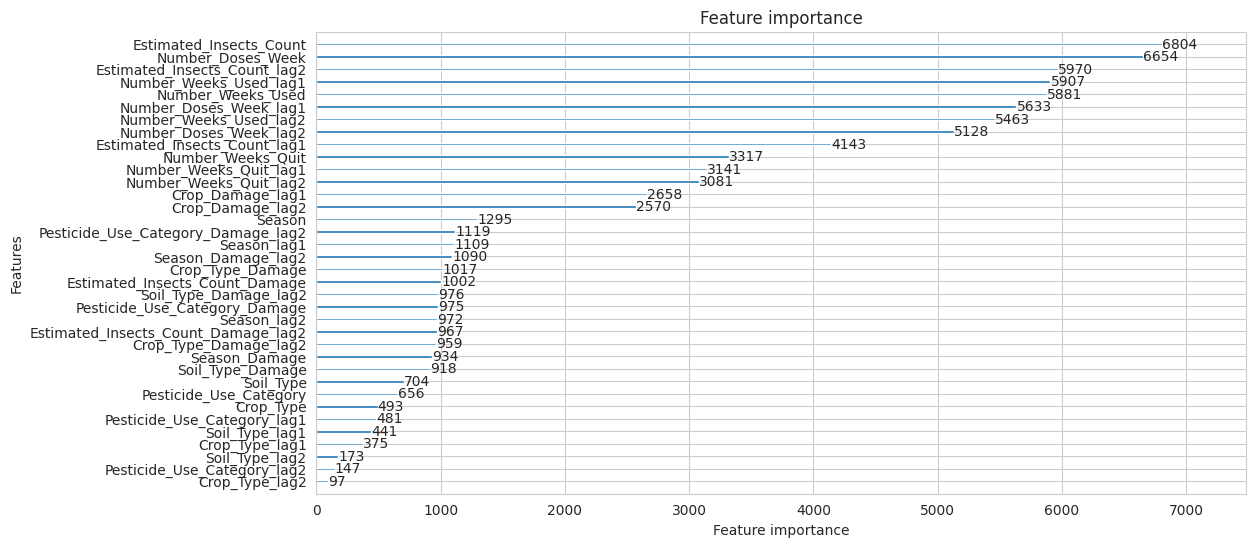

In [37]:
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()

In [ ]:
## some hard-coding done in excel for marginal probability values to improve accuracy (by ~ 0.005).